# simulación de adsorción basada en el algoritmo de RIUS 


# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$



# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_probability as tfp
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe_connected'  # más estable en algunos entornos

2025-04-29 21:31:50.488800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745962310.710363      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745962310.778374      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.700e-3 #Fondo del pozo del aluminio (j/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10031 #Fondo del pozo mercurio (j/mol)
Sigma_I_L = np.sqrt(SigmaAl*SigmaHg)
Epsilon_I_L = np.sqrt(EpsilonAl*EpsilonHg)
Sigma_I_I = np.sqrt(SigmaHg*SigmaHg)
Epsilon_I_I = np.sqrt(EpsilonHg*EpsilonHg)
r_cutoff_I_L = 3*Sigma_I_L #Radio maximo de interacción ion atomo(A)
r_cutoff_I_I = 3*Sigma_I_I #Radio maximo de interacción ion ion(A)

# Creación de la muestra

Número total de átomos FCC (esfera): 2108


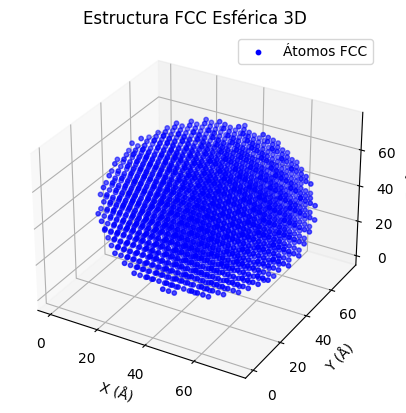

In [3]:
# Dimensiones de la red FCC
celdas_largo = 10
celdas_alto = 10
celdas_profundidad = 10

# --- Posiciones relativas dentro de una celda FCC ---
relativas_fcc = np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.5, 0.0],
    [0.5, 0.0, 0.5],
    [0.0, 0.5, 0.5]
])


# --- Centro y radio de la esfera ---
centro = np.array([celdas_largo, celdas_alto, celdas_profundidad]) * a / 2  # centrada en medio de la red
diametro_esfera = min(celdas_largo, celdas_alto, celdas_profundidad) * a
radio_esfera = diametro_esfera / 2

# --- Posiciones relativas dentro de una celda FCC ---
relativas_fcc = np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.5, 0.0],
    [0.5, 0.0, 0.5],
    [0.0, 0.5, 0.5]
])

# --- Generar estructura FCC con forma de esfera ---
posiciones = []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        for k in range(celdas_profundidad):
            for rel in relativas_fcc:
                pos = a * (np.array([i, j, k]) + rel)
                if np.linalg.norm(pos - centro) <= radio_esfera:
                    posiciones.append(pos)

fcc_positions = np.array(posiciones)
num_atoms = fcc_positions.shape[0]
print("Número total de átomos FCC (esfera):", num_atoms)

# --- Gráfica 3D ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], s=10, color='blue', label="Átomos FCC")

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('Estructura FCC Esférica 3D')
ax.legend()
plt.show()


# Creación de los iones que se van a adsorber

In [4]:
num_iones = 100  # Número de átomos extra que se colocarán al azar
x_lim = celdas_largo*a #Como es un cubo, en general el limite es el mismo en todas las direcciones,
                      #Si tuviera dimensiones diferentes necesitaria y_lim y z_lim tambien

#Listas vacias para guardar las nuevas posiciones de los iones
x_extra=[]
y_extra=[]
z_extra=[]

min_dist = radio_esfera + 0.3 * Sigma_I_L
max_dist = radio_esfera + 2.0 * Sigma_I_L

for _ in range(num_iones):
    while True:
        vec = np.random.normal(size=3)
        vec /= np.linalg.norm(vec)
        r = np.random.uniform(min_dist, max_dist)
        pos_extra = centro + vec * r
        x_extra.append(pos_extra[0])
        y_extra.append(pos_extra[1])
        z_extra.append(pos_extra[2])
        break

extra_positions = np.column_stack((x_extra, y_extra, z_extra)) # Matriz con posiciones de iones
#print(extra_positions)

# --- Gráfica 3D Interactiva con Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=fcc_positions[:, 0],
    y=fcc_positions[:, 1],
    z=fcc_positions[:, 2],
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Átomos FCC'
))

fig.add_trace(go.Scatter3d(
    x=extra_positions[:, 0],
    y=extra_positions[:, 1],
    z=extra_positions[:, 2],
    mode='markers',
    marker=dict(size=4, color='red', symbol='x'),
    name='Átomos extra'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)'
    ),
    title='Estructura FCC Esférica 3D con Átomos Extra (Interactiva)',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [5]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon, sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term #+ epsilon #Suma epsilon para desplazar el fondo del potencial a 0

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon_l=Epsilon_I_L, sigma_l=Sigma_I_L, epsilon_i=Epsilon_I_I, sigma_i=Sigma_I_I, r_cutoff_I_L=r_cutoff_I_L, r_cutoff_I_I=r_cutoff_I_I):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 3)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 3)

    Returns:
        Energía promedio del sistema (escalar)
    """
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------

    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    #Eliminar los atomos muy lejanos que no interactuan
    interaction_mask = r <= r_cutoff_I_L #mascara para reducir la matriz de distacias
    #indices de las interacciones validas
    indices = tf.where(interaction_mask)  # shape: (num_valid, 2)
    ion_idx = indices[:, 0]

    valid_r = tf.gather_nd(r, indices)#distancias validas
    valid_r = tf.where(valid_r == 0, 1e-10, valid_r)# Evitar divisiones por cero

    # Calcular el potencial de Lennard-Jones para cada interacción ion atomo
    valid_energy = lennard_jones_potential(valid_r, epsilon_l, sigma_l) # (num_iones, num_superficie)

    #Suma la energia total por ion
    ion_energy_sum = tf.math.unsorted_segment_sum(valid_energy, ion_idx, tf.shape(Xh)[0])
    ion_counts = tf.math.unsorted_segment_sum(tf.ones_like(valid_energy), ion_idx, tf.shape(Xh)[0])
    ion_counts_safe = tf.where(ion_counts == 0, 1.0, ion_counts)

    # Energía promedio para cada ion y todos los atomos
    ion_lattice_energy = ion_energy_sum / ion_counts_safe  # divide solo por los atomos que interactuaron

    #----------------------INTERACCIONES ION-ION-------
    ion_indices = tf.range(tf.shape(Xh)[0]) #Define los indices que identifican a cada ion
    ion_pairs = tf.stack(tf.meshgrid(ion_indices, ion_indices, indexing='ij'),axis=-1) #Define una estructura con todas las combinaciones posibles de indices, y las combina en un tensor
    ion_pairs = tf.reshape(ion_pairs, [-1, 2])
    ion_pairs = tf.boolean_mask(ion_pairs, ion_pairs[:,0] < ion_pairs[:,1])#Filtra las parejas dubplicadas y la pareja formada consigo mismo

    diff_ion_ion = tf.gather(Xh, ion_pairs[:,0]) - tf.gather(Xh, ion_pairs[:,1])
    r_ion_ion = tf.norm(diff_ion_ion, axis=-1)
    valid_mask = r_ion_ion <= r_cutoff_I_I
    valid_pairs = tf.boolean_mask(ion_pairs, valid_mask)
    valid_r = tf.boolean_mask(r_ion_ion, valid_mask)
    valid_r = tf.where(valid_r == 0, 1e-10, valid_r)

    valid_energy = lennard_jones_potential(valid_r, epsilon_i, sigma_i)

    # Split energy between the two ions in each pair
    ion_i = valid_pairs[:,0]
    ion_j = valid_pairs[:,1]

    # Distribute energies equally to both ions
    energy_per_ion = tf.concat([valid_energy, valid_energy], axis=0)
    ion_indices_per_energy = tf.concat([ion_i, ion_j], axis=0)

    # Sum and count per ion
    ion_ion_energy_sum = tf.math.unsorted_segment_sum(energy_per_ion, ion_indices_per_energy, tf.shape(Xh)[0])
    ion_ion_counts = tf.math.unsorted_segment_sum(tf.ones_like(energy_per_ion), ion_indices_per_energy, tf.shape(Xh)[0])
    ion_ion_counts_safe = tf.where(ion_ion_counts == 0, 1.0, ion_ion_counts)

    # Per-ion average ion-ion interaction energy
    ion_ion_energy_per_ion = ion_ion_energy_sum / ion_ion_counts_safe

    # Devolver la energía promedio del sistema y la energía por ion
    ion_energies = ion_lattice_energy + ion_ion_energy_per_ion
    energy_total = tf.reduce_mean(ion_energies)
    return energy_total, ion_energies

In [6]:
#tensorflow data
ion = tf.Variable(extra_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
#lam_LJ = 0.4
#lam_ = tf.constant(lam_LJ,dtype=tf.float32)


2025-04-29 21:32:11.283339: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

In [8]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

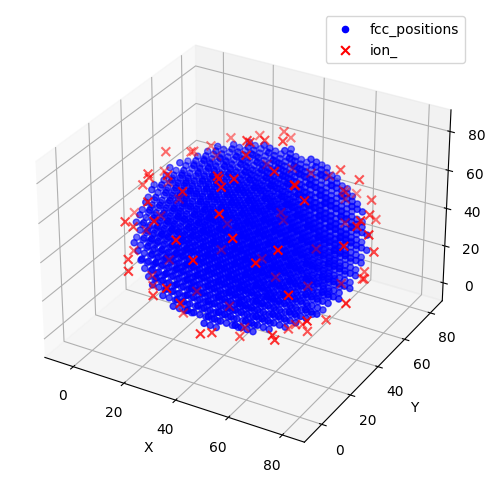

Epoch 1/500
Loss: 501.87823486328125 MeanGrad: [-1.7395685e-03  2.1696027e-04 -4.2399730e-05]


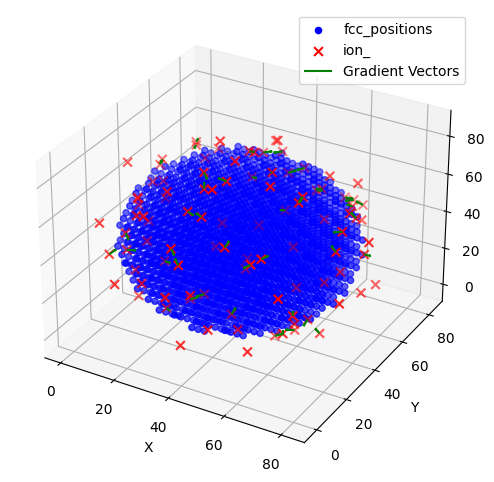

Epoch 2/500
Loss: -644.5425415039062 MeanGrad: [ 0.08339093 -0.04821437  0.00541874]


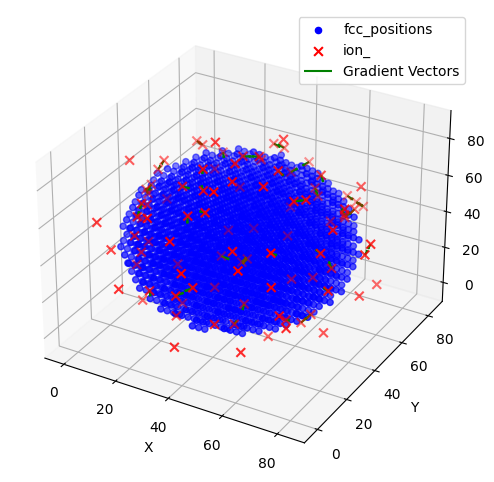

Epoch 3/500
Loss: 6732.00244140625 MeanGrad: [ 4.2465644   1.7284482  -0.22732525]


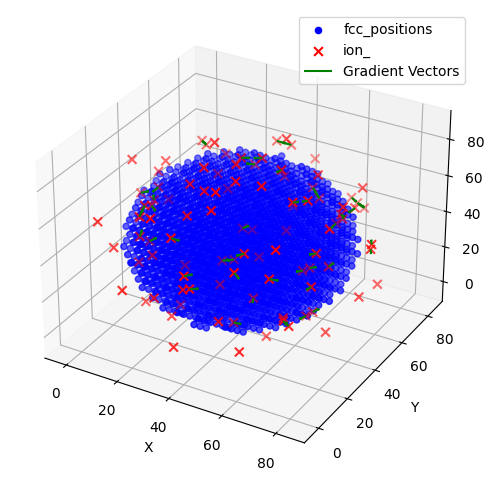

Epoch 4/500
Loss: -618.2976684570312 MeanGrad: [-3.4452745e-04 -5.5298911e-05  1.5509222e-04]


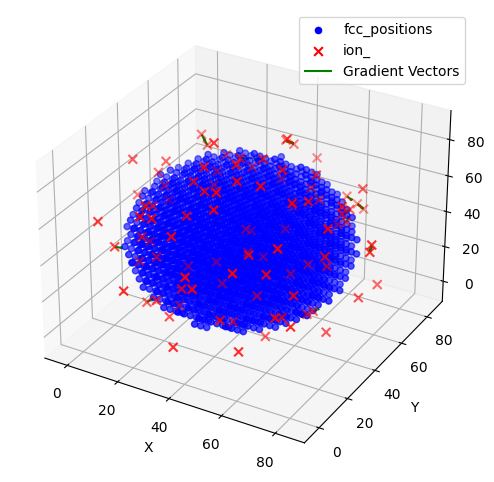

Epoch 5/500
Loss: -589.795654296875 MeanGrad: [-0.01215363  0.01226451 -0.00316304]


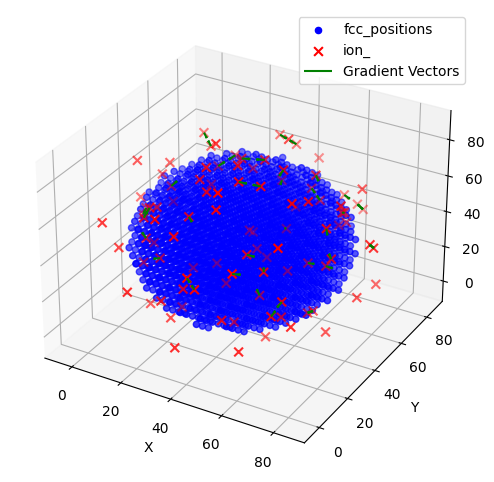

Epoch 6/500
Loss: -168.40892028808594 MeanGrad: [ 2.5546916  -0.3393074   0.25453395]


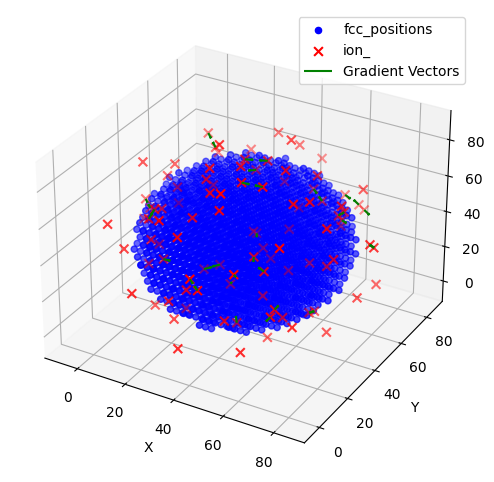

Epoch 7/500
Loss: -599.67822265625 MeanGrad: [-0.01437175  0.02710801 -0.00354477]
Early stopping at epoch 7


In [9]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

"""ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])"""

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()
# Custom training loop
eta0 = 1.0
batch_size = 256
epochs = 500
decay_rate = 0.10
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
E_total_log = []#Para guardar y graficar la energía del sistema

early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    #optimizer.learning_rate = eta
    for x_batch in tf.data.Dataset.from_tensor_slices(sample_atoms).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_,ion_energies = H_loss(ion,x_batch)
        E_total_log.append(float(H_loss_))
      grad_ = g.gradient(H_loss_, ion)
      optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    if early_stopping.on_epoch_end(epoch, H_loss_.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        last_loss = H_loss_.numpy()
        system_energy = last_loss-(num_atoms*num_iones*Epsilon_I_L)
        break

    ion_ =  ion.numpy()
    gradN = -10*eta0*grad_.numpy()


    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=20, label='fcc_positions')
    ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

    # For quiver, we need to create a 3D representation of the gradient
    # Assuming gradN is a 2D array (num_ions, 2)
    gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
    gradN_3D = gradN  # Copy x and y components from gradN

    ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
              color='g', length=3, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed

    """ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])"""

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

    if epoch+1==epochs:
      last_loss = H_loss_.numpy()
      system_energy = last_loss#-(num_atoms*num_iones*Epsilon_I_L)

In [10]:
print(f'Atomos en la muestra:{num_atoms}',f'- Iones a adsorber:{num_iones}')
print(f'Minima distancia para que no haya superposicion: {Sigma_I_L:.3f} A ',f'- Minima energía posible por ion: {-Epsilon_I_L:.3f} j/mol')
print(f'Energía promedio por ion:{system_energy/(num_atoms*num_iones):.3f} j/mol')
print(f"Energía final promedio por ion: {E_total_log[-1]:.3f} j/mol")# Revisar
print(f"Desviación estándar de energía por ion: {np.std(ion_energies):.3f} j/mol") #Revisar
distance=ion_-starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
print(f'Distancia viajada promedio (vectorial): {mean_vector}')

Atomos en la muestra:2108 - Iones a adsorber:100
Minima distancia para que no haya superposicion: 3.035 A  - Minima energía posible por ion: -8.789 j/mol
Energía promedio por ion:-8.791 j/mol
Energía final promedio por ion: -599.678 j/mol
Desviación estándar de energía por ion: 2205.422 j/mol
Distancia viajada promedio (vectorial): [0.16749518 0.87007105 0.5914035 ]


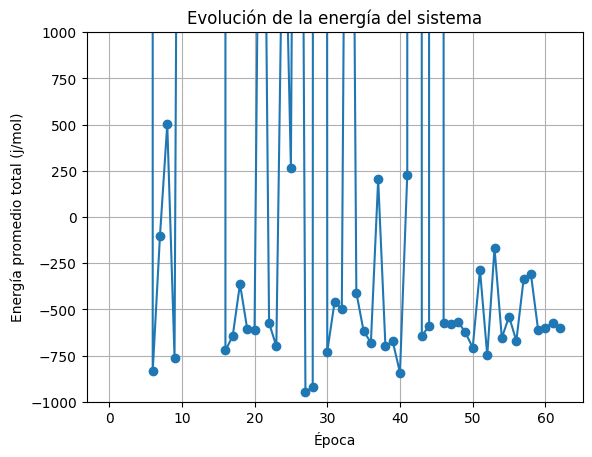

In [11]:
# --- Graficar evolución de energía total ---
import matplotlib.pyplot as plt
plt.plot(E_total_log, marker='o')
plt.xlabel("Época")
plt.ylabel("Energía promedio total (j/mol)")
plt.title("Evolución de la energía del sistema")
plt.grid(True)
plt.ylim(-1000,1000)
plt.show()

In [12]:
# --- Gráfica 3D Interactiva con Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=fcc_positions[:, 0],
    y=fcc_positions[:, 1],
    z=fcc_positions[:, 2],
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Átomos FCC'
))

fig.add_trace(go.Scatter3d(
    x=ion_[:, 0],
    y=ion_[:, 1],
    z=ion_[:, 2],
    mode='markers',
    marker=dict(size=4, color='red', symbol='x'),
    name='Átomos extra'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)'
    ),
    title='Estructura FCC Esférica 3D con Átomos Extra (Interactiva)',
    legend=dict(x=0.01, y=0.99)
)

fig.show()